<a href="https://colab.research.google.com/github/albogdan/aps360-project/blob/master/HOGonLego.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test HOG with astronauts

In [ ]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure

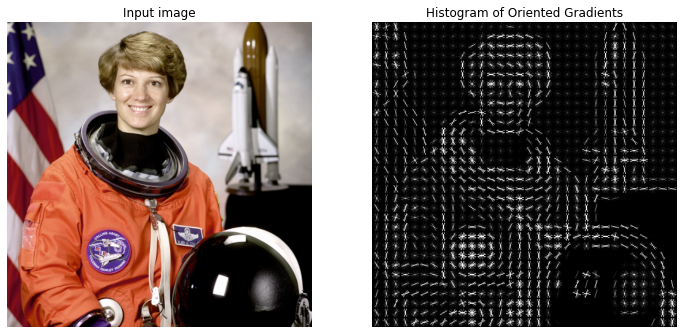

In [ ]:
image = data.astronaut()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

#HOG for face detection

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
print(type(positive_patches))
print(positive_patches.shape)

<class 'numpy.ndarray'>
(13233, 62, 47)


In [ ]:
from skimage import data, transform, color
import numpy as np
from sklearn.feature_extraction.image import PatchExtractor

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]
 
 
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])


In [ ]:
from skimage import feature   
from itertools import chain

X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV 

grid = GridSearchCV(LinearSVC(dual=False), {'C': [1.0, 2.0, 4.0, 8.0]},cv=3)
grid.fit(X_train, y_train)
grid.best_score_

0.9891286748548563

In [ ]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

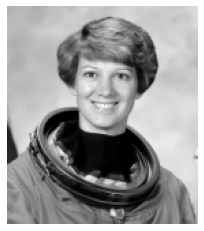

In [ ]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [ ]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

In [ ]:
labels = model.predict(patches_hog)
labels.sum()

49.0

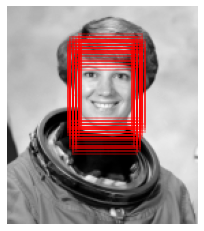

In [ ]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

#Training on Legos


In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import os
import time
from google.colab import output

from skimage.feature import hog
from skimage import data, exposure, transform, color, io
from sklearn.feature_extraction.image import PatchExtractor
from skimage import feature   
from itertools import chain
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV 

In [ ]:
def progressBar(current, total, barLength = 20):
    output.clear('progress_bar')
    with output.use_tags('status_text'):
      percent = float(current) * 100.0 / total
      arrow   = '-' * int(percent/100 * barLength - 1) + '>'
      spaces  = ' ' * (barLength - len(arrow))
      print("Progress: [{}{}] {} %".format(arrow, spaces, percent))

#Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if os.path.exists(os.path.expanduser('~/pieces')):
  !rm -rf {os.path.expanduser('~/pieces')}
!unzip '/content/drive/My Drive/APS360 Project/share/BerendImages/mayacaptures.zip' -d {os.path.expanduser('~/pieces')}

In [ ]:
legoPieceRootPath = os.path.expanduser('~/pieces')
legoPartsIDs = os.listdir(legoPieceRootPath)
# combine these two to get directories of all the pieces

(400, 400, 3)
[[[10946.07176114 10946.07176114 10946.07176114]]]


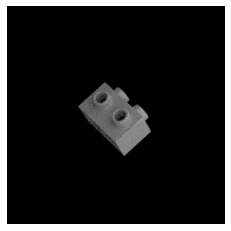

In [ ]:
imageArray = io.imread(os.path.expanduser('~/pieces/11211/11211 000L_1.png'))
print(imageArray.shape)
print(np.linalg.norm(imageArray, None, (0, 1), True))
plt.imshow(imageArray)
plt.axis('off');

(80, 80, 3)


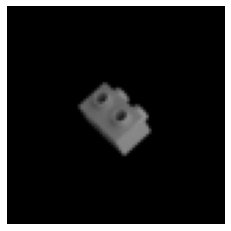

In [ ]:
transformed = transform.resize(imageArray, (80, 80), 1, anti_aliasing=True)
plt.imshow(transformed)
plt.axis('off');
print(transformed.shape)

In [ ]:
# how many samples do we have
totalCount = len(legoPartsIDs) * 800
# for folder in legoPartsIDs:
#   path = os.path.join(legoPieceRootPath, folder)
#   files = os.listdir(path)
#   print("{} folder has {} images".format(folder, len(files)))

In [ ]:
# put them all in a large ndarray
legoSamples = np.empty((totalCount, 80, 80))
index = 0
for folder in legoPartsIDs:
  for image in os.listdir(os.path.join(legoPieceRootPath, folder)):
    imageArray = io.imread(os.path.join(legoPieceRootPath, folder, image))
    imageArray = transform.resize(imageArray, (80, 80), 1, anti_aliasing=True)
    imageArray = color.rgb2gray(imageArray)
    legoSamples[index, :] = imageArray.copy()
    if (index % 20 == 0):
      progressBar(index, totalCount, 40)
    index += 1

Progress: [--------------------------------------> ] 99.9074074074074 %


In [ ]:
# Only do one piece
totalCount = 800
legoSamples = np.empty((800, 80, 80))
index = 0
folder = "3660"
for image in os.listdir(os.path.join(legoPieceRootPath, folder)):
  imageArray = io.imread(os.path.join(legoPieceRootPath, folder, image))
  imageArray = transform.resize(imageArray, (80, 80), 1, anti_aliasing=True)
  imageArray = color.rgb2gray(imageArray)
  legoSamples[index, :] = imageArray.copy()
  if (index % 20 == 0):
    progressBar(index, totalCount, 40)
  index += 1

Progress: [--------------------------------------> ] 97.5 %


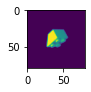

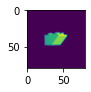

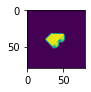

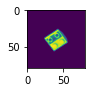

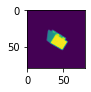

In [ ]:
n = 5  # for 2 random indices
index = np.random.choice(legoSamples.shape[0], n, replace=False)

for k in range(0, n, 1):
    plt.figure(figsize=(6, 6))
    img = legoSamples[index[k]][:]
    plt.subplot(1, n, k+1)
    plt.imshow(img)

In [ ]:
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]
print(len(images))
 
 
def extract_patches(img, N, scale=1.0, patch_size=legoSamples[0].shape):
    print(img.shape)
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0]])

10
(512, 512)
(512, 512)
(172, 448)
(172, 448)
(303, 384)
(303, 384)
(512, 512)
(512, 512)
(191, 384)
(191, 384)
(300, 400)
(300, 400)
(512, 512)
(512, 512)
(300, 451)
(300, 451)
(400, 600)
(400, 600)
(872, 1000)
(872, 1000)


In [ ]:
print(legoSamples.shape)
print(negative_patches.shape)

(800, 80, 80)
(20000, 80, 80)


In [ ]:
X_train = np.array([feature.hog(im, orientations=12, pixels_per_cell=(4,4), cells_per_block=(2,2))
                    for im in chain(legoSamples,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:legoSamples.shape[0]] = 1

In [ ]:
print(X_train.shape)

(20800, 17328)


In [ ]:
grid = GridSearchCV(LinearSVC(dual=False), {'C': [1.0, 2.0, 4.0, 8.0]},cv=3)
grid.fit(X_train, y_train)
grid.best_score_

1.0

In [ ]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
!rm -rf {os.path.expanduser('~/Images')}
!rm -rf {os.path.expanduser('~/__MACOSX')}

In [ ]:
if os.path.exists(os.path.expanduser('~/BerendImages')):
  !rm -rf {os.path.expanduser('~/BerendImages')}
!unzip '/content/drive/My Drive/APS360 Project/ObjectDetectionImages/BerendImages.zip' -d {os.path.expanduser('~/BerendImages')}

In [ ]:
!rm -rf {os.path.expanduser('~/BerendImages/__MACOSX')}

(400, 400, 3)
(84, 84)


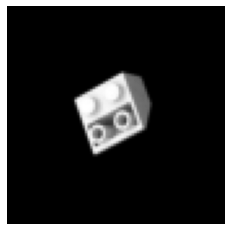

In [ ]:
test_image = io.imread(os.path.expanduser('~/pieces/3660/3660 378R_1.png'))
print(test_image.shape)
test_image = color.rgb2gray(test_image)
test_image = transform.rescale(test_image, 0.21)
print(test_image.shape)

plt.imshow(test_image, cmap='gray')
plt.axis('off');

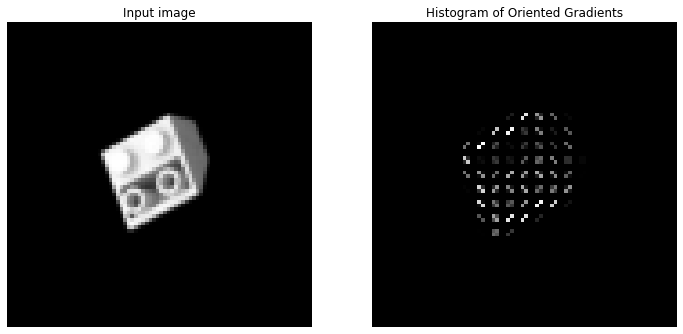

In [ ]:
fd, hog_image = hog(test_image, orientations=12, pixels_per_cell=(4, 4),
                    cells_per_block=(2, 2), visualize=True, multichannel=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(test_image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [ ]:
def sliding_window(img, patch_size=legoSamples[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    print(patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [ ]:
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch, orientations=12, pixels_per_cell=(4,4), cells_per_block=(2,2)) for patch in patches])
patches_hog.shape

(80, 80)


(4, 17328)

In [ ]:
labels = model.predict(patches_hog)
labels.sum()

4.0

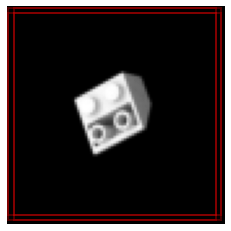

In [ ]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = legoSamples[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

(3072, 4608, 3)
(307, 461)


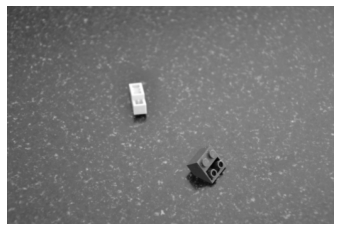

In [ ]:
test_image = io.imread(os.path.expanduser('~/BerendImages/Images/B_100.jpg'))
print(test_image.shape)
test_image = color.rgb2gray(test_image)
test_image = transform.rescale(test_image, 0.1)
print(test_image.shape)

plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [ ]:
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(21774, 5184)

In [ ]:
labels = model.predict(patches_hog)
labels.sum()

0.0

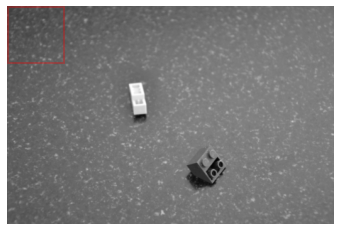

In [ ]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = legoSamples[0].shape
indices = np.array(indices)

for i, j in indices:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))
    break

(3024, 4032, 3)
(454, 605)


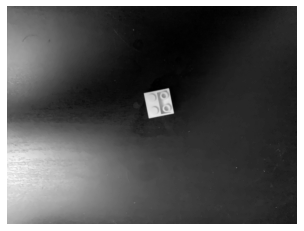

In [ ]:
test_image = io.imread(os.path.expanduser('~/BerendImages/Images/IMG_6836.jpg'))
print(test_image.shape)
test_image = color.rgb2gray(test_image)
test_image = transform.rescale(test_image, 0.15)
print(test_image.shape)

plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [ ]:
indices, patches = zip(*sliding_window(test_image, (80, 80), 40, 40, 1.0))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(140, 5184)

In [ ]:
labels = model.predict(patches_hog)
labels.sum()

0.0

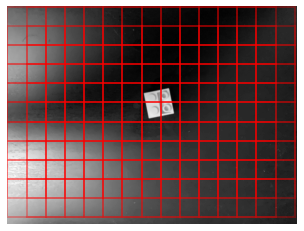

In [ ]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = legoSamples[0].shape
indices = np.array(indices)

for i, j in indices:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

(649, 652, 3)
(84, 85)


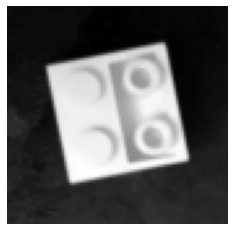

In [ ]:
test_image = io.imread(os.path.expanduser('~/BerendImages/Images/IMG_6836_cropped.jpg'))
print(test_image.shape)
test_image = color.rgb2gray(test_image)
test_image = transform.rescale(test_image, 0.13)
print(test_image.shape)

plt.imshow(test_image, cmap='gray')
plt.axis('off');

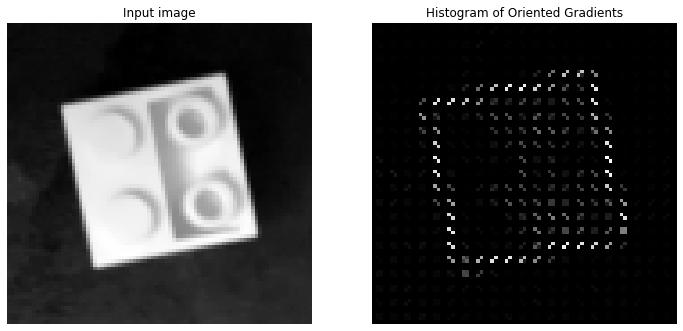

In [ ]:
fd, hog_image = hog(test_image, orientations=12, pixels_per_cell=(4, 4),
                    cells_per_block=(2, 2), visualize=True, multichannel=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(test_image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [ ]:
indices, patches = zip(*sliding_window(test_image, (80, 80)))
patches_hog = np.array([feature.hog(patch, orientations=12, pixels_per_cell=(4,4), cells_per_block=(2,2)) for patch in patches])
patches_hog.shape

(80, 80)


(6, 17328)

In [ ]:
labels = model.predict(patches_hog)
labels.sum()

0.0

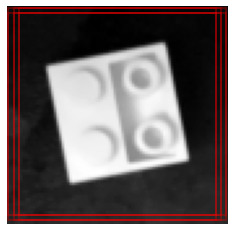

In [ ]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = legoSamples[0].shape
indices = np.array(indices)

for i, j in indices:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

# training with noise

In [ ]:
# Only do one piece
totalCount = 800
dim = 120
legoSamples = np.empty((800, dim, dim))
index = 0
folder = "3660"
for image in os.listdir(os.path.join(legoPieceRootPath, folder)):
  imageArray = io.imread(os.path.join(legoPieceRootPath, folder, image))
  imageArray = transform.resize(imageArray, (dim, dim), 1, anti_aliasing=True)
  imageArray = color.rgb2gray(imageArray)
  imageArray = imageArray + np.random.normal(loc = 0.0, scale = 2e-2, size = imageArray.shape)
  # fig, ax = plt.subplots()
  # ax.imshow(imageArray, cmap='gray')
  # ax.axis('off')
  # break
  legoSamples[index, :] = imageArray.copy()
  if (index % 20 == 0):
    progressBar(index, totalCount, 40)
  index += 1

Progress: [--------------------------------------> ] 97.5 %


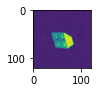

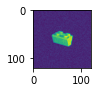

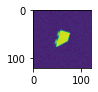

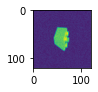

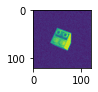

In [ ]:
n = 5  # for 2 random indices
index = np.random.choice(legoSamples.shape[0], n, replace=False)

for k in range(0, n, 1):
    plt.figure(figsize=(6, 6))
    img = legoSamples[index[k]][:]
    plt.subplot(1, n, k+1)
    plt.imshow(img)

In [ ]:
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]
print(len(images))
 
 
def extract_patches(img, N, scale=1.0, patch_size=legoSamples[0].shape):
    print(img.shape)
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0]])

10
(512, 512)
(512, 512)
(172, 448)
(172, 448)
(303, 384)
(303, 384)
(512, 512)
(512, 512)
(191, 384)
(191, 384)
(300, 400)
(300, 400)
(512, 512)
(512, 512)
(300, 451)
(300, 451)
(400, 600)
(400, 600)
(872, 1000)
(872, 1000)


In [ ]:
X_train = np.array([feature.hog(im, orientations=12, pixels_per_cell=(4,4), cells_per_block=(2,2))
                    for im in chain(legoSamples,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:legoSamples.shape[0]] = 1

In [ ]:
grid = GridSearchCV(LinearSVC(dual=False), {'C': [1.0, 2.0, 4.0, 8.0]},cv=3)
grid.fit(X_train, y_train)
grid.best_score_

1.0

In [ ]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

(400, 400, 3)
(85, 85)


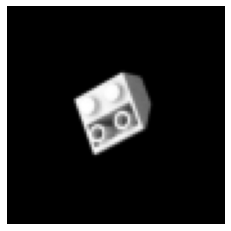

In [ ]:
test_image = io.imread(os.path.expanduser('~/pieces/3660/3660 378R_1.png'))
print(test_image.shape)
test_image = color.rgb2gray(test_image)
test_image = transform.resize(test_image, (dim+5, dim+5))
print(test_image.shape)

plt.imshow(test_image, cmap='gray')
plt.axis('off');

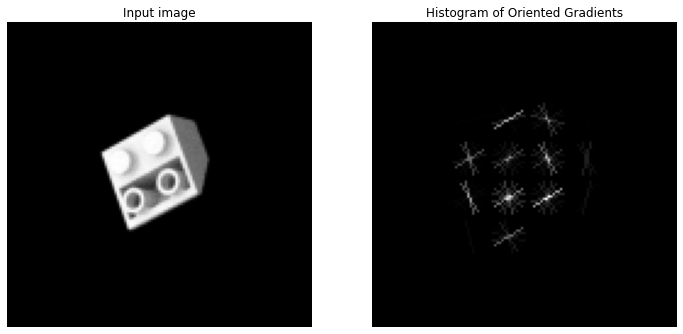

In [ ]:
fd, hog_image = hog(test_image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(test_image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [ ]:
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(80, 80)


(9, 5184)

In [ ]:
labels = model.predict(patches_hog)
labels.sum()

ValueError: ignored

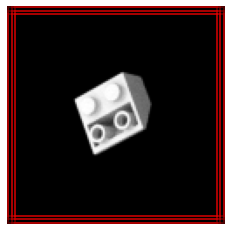

In [ ]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = legoSamples[0].shape
indices = np.array(indices)

for i, j in indices:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))